In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# pre-processing
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# dimension reduction, for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

# model trainging
from sklearn.base import clone
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, GridSearchCV

# models
from xgboost import XGBClassifier, XGBRFClassifier                          # XGBoost
from sklearn.neighbors import NearestCentroid                               # nearest centroid
from sklearn.linear_model import LogisticRegression                         # logisic regression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier                             # classification tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier     # AdaBoost, random forest
from sklearn.neural_network import MLPClassifier                            # neural network (MLP)
from sklearn.svm import SVC                                                 # SVM
from sklearn.neighbors import KNeighborsClassifier                          # KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis        # LDA
from sklearn.naive_bayes import GaussianNB                                  # naive bayes
from sklearn.ensemble import StackingClassifier, VotingClassifier           # stacking, voting

# evaluation
from sklearn.inspection import permutation_importance                       # generic feature importance
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, f1_score


In [2]:
### General Setup

# import data
darwin = pd.read_csv('DARWIN.csv')
darwin.drop('ID', axis=1, inplace=True)

# numeric summaries
darwin.describe()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,...,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,1.740000e+02
mean,5664.166667,0.000010,297.666685,200.504413,1977.965517,7323.896552,0.416374,0.179823,249.085549,0.067556,...,221.360646,0.148286,0.019934,4.472643,2.871613,85.839080,43109.712644,1629.585962,163061.767360,1.642033e+05
std,12653.772746,0.000003,183.943181,111.629546,1648.306365,2188.290512,0.381837,0.064693,132.698462,0.074776,...,63.762013,0.062207,0.002388,1.501411,0.852809,27.485518,19092.024337,324.142316,56845.610814,4.969397e+05
min,65.000000,0.000002,28.734515,29.935835,754.000000,561.000000,0.067748,0.096631,41.199445,0.011861,...,69.928033,0.030169,0.014987,1.323565,0.950249,32.000000,15930.000000,474.049462,26984.926660,2.998000e+04
25%,1697.500000,0.000008,174.153023,136.524742,1362.500000,6124.000000,0.218209,0.146647,161.136182,0.029523,...,178.798382,0.107732,0.018301,3.485934,2.401199,66.000000,32803.750000,1499.112088,120099.046800,5.917500e+04
50%,2890.000000,0.000009,255.791452,176.494494,1681.000000,6975.500000,0.275184,0.163659,224.445268,0.039233,...,217.431621,0.140483,0.019488,4.510578,2.830672,81.000000,37312.500000,1729.385010,158236.771800,7.611500e+04
75%,4931.250000,0.000011,358.917885,234.052560,2082.750000,8298.500000,0.442706,0.188879,294.392298,0.071057,...,264.310776,0.199168,0.021134,5.212794,3.335828,101.500000,46533.750000,1865.626974,200921.078475,1.275425e+05
max,109965.000000,0.000028,1168.328276,865.210522,18602.000000,15783.000000,2.772566,0.627350,836.784702,0.543199,...,437.373267,0.375078,0.029227,10.416715,5.602909,209.000000,139575.000000,1999.775983,352981.850000,5.704200e+06


In [3]:
## Pre-processing

# extract target variable
X = darwin.drop('class', axis=1)
y = darwin['class']
y_int = (y == 'P').astype(int)

# transform skewed data
X_log = X.copy()
for j in X_log.columns:
    col = X[j]
    if np.min(col) > 0:
        transf = np.log(col)
    else:
        transf = np.arcsinh(col)
    
    if stats.skew(transf) < stats.skew(col):
        X_log[j] = transf

# train-test split
X_train_noncentered, X_test_noncentered, y_train, y_test = train_test_split(X_log, y, train_size=0.7, random_state=90095)

# convert labels to int
y_train = (y_train == "P").astype(int)
y_test = (y_test == "P").astype(int)

# scale and center training data
scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train_noncentered)

# scale and center test data
scaler_test = StandardScaler()
X_test = scaler_test.fit_transform(X_test_noncentered)

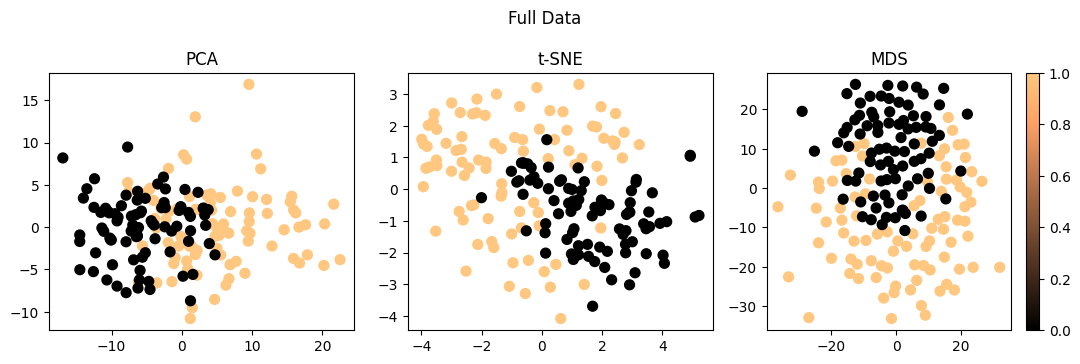

In [4]:
## Lower-dimensional representation

# scale and center data
full_scaler = StandardScaler()
X_full = full_scaler.fit_transform(X_log)


# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

# t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', random_state=90095, perplexity=50)
X_tsne = tsne.fit_transform(X_full)

# MDS
mds = MDS(n_components=2, random_state=90095, normalized_stress='auto') 
X_mds = mds.fit_transform(X_full)

# plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 11/3))
fig.suptitle('Full Data')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_int, cmap='copper', s=50)
ax1.set_title('PCA')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_int, cmap='copper', s=50)
ax2.set_title('t-SNE')
ax3.scatter(X_mds[:, 0], X_mds[:, 1], c=y_int, cmap='copper', s=50)
ax3.set_title('MDS')
plt.colorbar(mpl.cm.ScalarMappable(cmap='copper'), ax=ax3)
plt.tight_layout()
# plt.savefig('Full_Data_Plot.png', dpi=300)
plt.show()

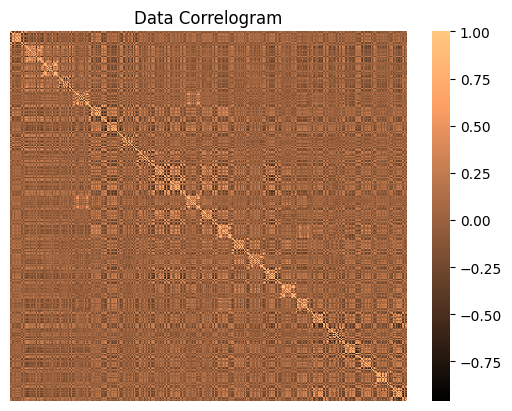

In [5]:
# correlation matrix
X_corr = pd.DataFrame(X_full).corr()

sns.heatmap(X_corr, cmap='copper', xticklabels=False, yticklabels=False)
plt.title('Data Correlogram')
# plt.savefig('Full_Data_Correlogram.png', dpi=300)
plt.show()

In [6]:
### Interlude: Train Control & Auxiliary Functions

# set up repeated 10-fold CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=90095)

# define specificity metric
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)
specificity = make_scorer(specificity_score)

In [7]:
## Plotting model fit

# subset test data
X_pca_test = X_pca[y_test.index,:]
X_tsne_test = X_tsne[y_test.index,:]
X_mds_test = X_mds[y_test.index,:]

# plot model predictions scatterplot
def plot_model(y_pred, model_title):
    """y_pred: predictions for TEST set"""
    incorrect_pred = np.round(y_pred) != y_test
    n_incorrect = np.sum(incorrect_pred)
    incorrect_color = ["magenta" for y in range(n_incorrect)]


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 11/3))
    fig.suptitle(model_title)


    if n_incorrect > 0:
        ax1.set_title('PCA')
        ax1.scatter(X_pca_test[incorrect_pred, 0], X_pca_test[incorrect_pred, 1], c=incorrect_color, s=65)
        ax1.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=y_pred, cmap='copper', s=35)

        ax2.set_title('t-SNE')
        ax2.scatter(X_tsne_test[incorrect_pred, 0], X_tsne_test[incorrect_pred, 1], c=incorrect_color, s=65)
        ax2.scatter(X_tsne_test[:, 0], X_tsne_test[:, 1], c=y_pred, cmap='copper', s=35)

        ax3.set_title('MDS')
        ax3.scatter(X_mds_test[incorrect_pred, 0], X_mds_test[incorrect_pred, 1], c=incorrect_color, s=65)
        ax3.scatter(X_mds_test[:, 0], X_mds_test[:, 1], c=y_pred, cmap='copper', s=35)

    else:
        ax1.set_title('PCA')
        ax1.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=y_pred, cmap='copper', s=55)
        ax2.set_title('t-SNE')
        ax2.scatter(X_tsne_test[:, 0], X_tsne_test[:, 1], c=y_pred, cmap='copper', s=55)
        ax3.set_title('MDS')
        ax3.scatter(X_mds_test[:, 0], X_mds_test[:, 1], c=y_pred, cmap='copper', s=55)
        
    plt.colorbar(mpl.cm.ScalarMappable(cmap='copper'), ax=ax3)

In [8]:
## Other auxiliary functions

# CV performance metrics
def cv_accuracy(model, title):
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    sen = cross_val_score(model, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
    spe = cross_val_score(model, X_train, y_train, scoring=specificity, cv=cv, n_jobs=-1)
    f1sc = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

    metrics_df = pd.DataFrame(
        {title: [acc.mean(),
                 sen.mean(),
                 spe.mean(),
                 f1sc.mean()]},
        index=['Accuracy', 'Sensitivity', 'Specificity','F1']
    )
    return metrics_df

# test performance metrics
def test_accuracy(y_pred_labels, title, y_true=y_test):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred_labels)
    sen = recall_score(y_true=y_true, y_pred=y_pred_labels)
    spe = specificity_score(y_true=y_true, y_pred=y_pred_labels)
    f1sc = f1_score(y_true=y_true, y_pred=y_pred_labels)

    metrics_df = pd.DataFrame(
        {title: [acc, sen, spe, f1sc]},
        index=['Accuracy', 'Sensitivity', 'Specificity','F1']
    )
    return metrics_df

# plot confusion matrix
def plot_cm(y_pred_labels, model_title):
    """y_pred_labels: predictions for TEST set"""
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred_labels, normalize='all')
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot(cmap='copper')
    plt.title(model_title)

# plot ROC curve
def plot_roc(y_pred_labels, model_title):
    """y_pred_labels: predicted LABELS for TEST set"""
    fpr, tpr, _ = roc_curve(y_test, y_pred_labels)
    roc_auc = roc_auc_score(y_test, y_pred_labels)
    plt.figure(figsize=(5.5, 5.5))
    plt.plot(fpr, tpr, color='chocolate', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: ' + model_title)
    plt.legend(loc="lower right")

# plot feature importance
def plot_feature_importances(model, model_title):
    """bar plot the feature importance"""

    tree = hasattr(model, 'feature_importances_') # determine if method is tree-based

    if tree:
        result = model.feature_importances_
        xlab = 'Feature Importance'
    else:
        result = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=90095, n_jobs=-1)["importances_mean"]
        xlab = 'Impurity-Based Relative Importance'
    indices = result.argsort()[::-1]
    means = result[indices]
    vars = X.columns[indices]
    means_zeroed = (means - np.min(means))
    means_scaled = 100 * (means_zeroed / np.max(means_zeroed))

    top_n = np.min([np.sum(means_scaled > 0), 10])

    plt.figure(figsize=(6, 4))
    plt.barh(range(top_n, 0, -1), means_scaled[:top_n], tick_label=vars[:top_n], color='#e7ba84')
    plt.ylabel('Features')
    plt.xlabel(xlab)
    plt.title(f'Top {top_n} Features: {model_title}')
    plt.tight_layout()

train:
                    NC
Accuracy     0.823205
Sensitivity  0.776667
Specificity  0.869048
F1           0.809918


test:
                    NC
Accuracy     0.716981
Sensitivity  0.689655
Specificity  0.750000
F1           0.727273


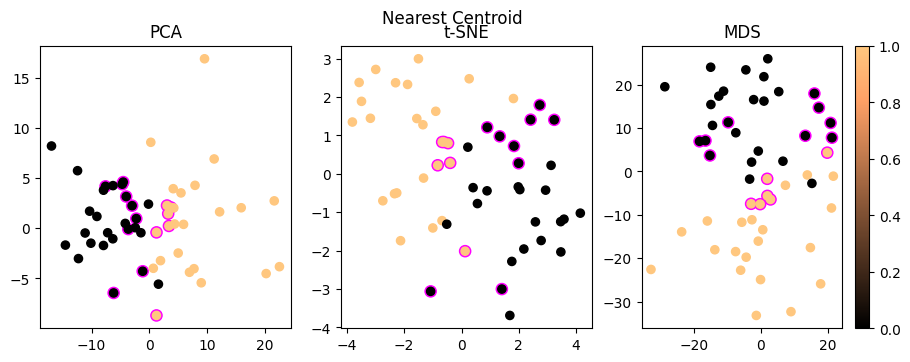

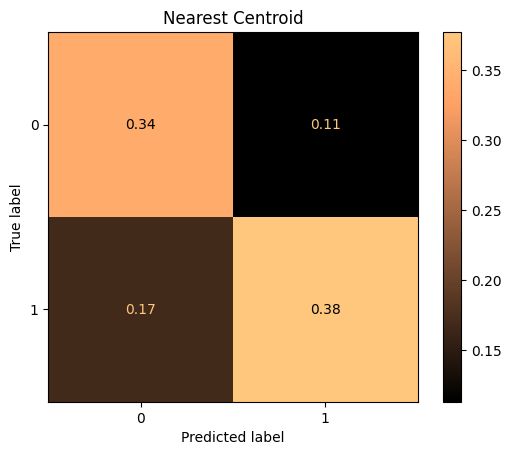

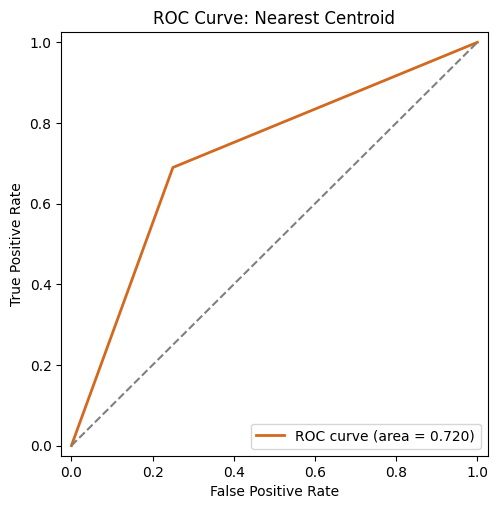

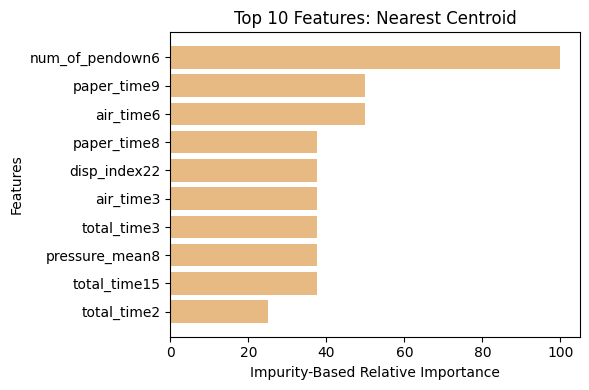

In [9]:
### Model 0: Nearest Centroid

# model specification
mod_nc = NearestCentroid()
# cross-validation
mod_nc_cv_metrics = cv_accuracy(mod_nc, 'NC')

# predict training, for out-of-sample evaluation
mod_nc_train = mod_nc.fit(X_train, y_train)
mod_nc_pred_test = mod_nc_train.predict(X_test)         # estimate test data

# prediction metrics
mod_nc_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_nc_pred_test, title='NC')

print('train:\n', mod_nc_cv_metrics)
print('\n\ntest:\n', mod_nc_test_metrics)

plot_model(y_pred=mod_nc_pred_test, model_title='Nearest Centroid')
# plt.savefig('Model-Nearest_Centroid.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_nc_pred_test, model_title='Nearest Centroid')
# plt.savefig('CM-Nearest_Centroid.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_nc_pred_test, model_title='Nearest Centroid')
# plt.savefig('ROC-Nearest_Centroid.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_nc_train, model_title='Nearest Centroid')
# plt.savefig('Feat-Nearest_Centroid.png', dpi=300)
plt.show()

train:
                    LR
Accuracy     0.859872
Sensitivity  0.853333
Specificity  0.866667
F1           0.852728


test:
                    LR
Accuracy     0.830189
Sensitivity  0.758621
Specificity  0.916667
F1           0.830189


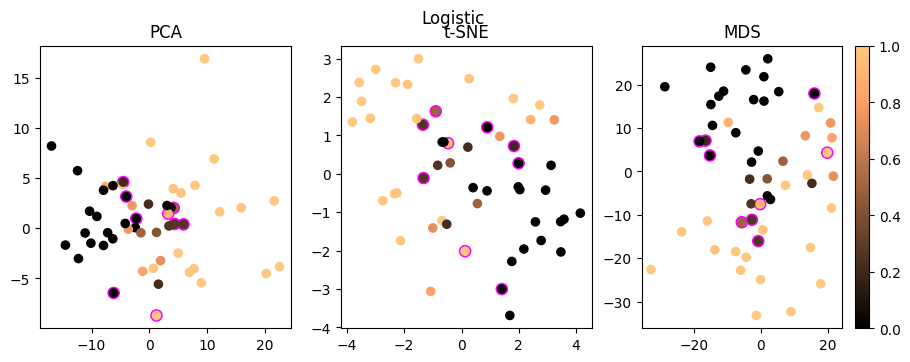

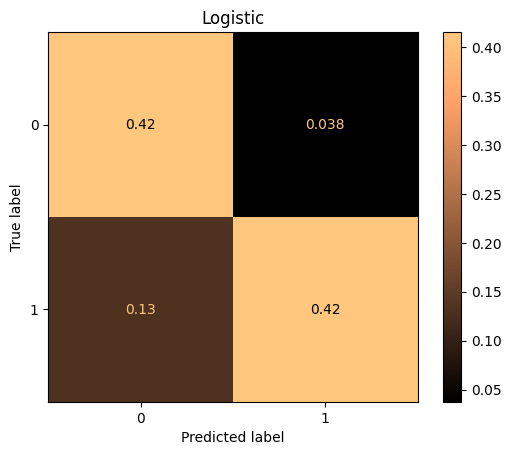

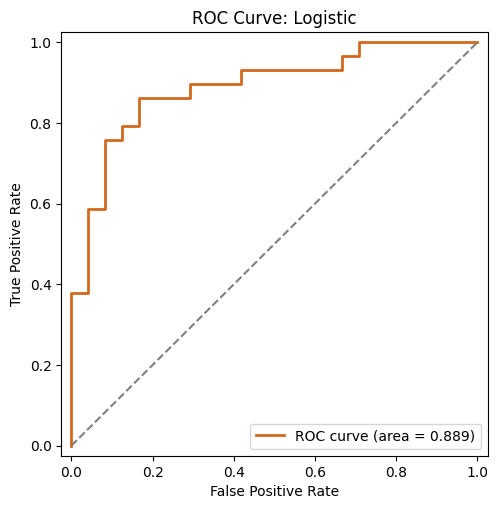

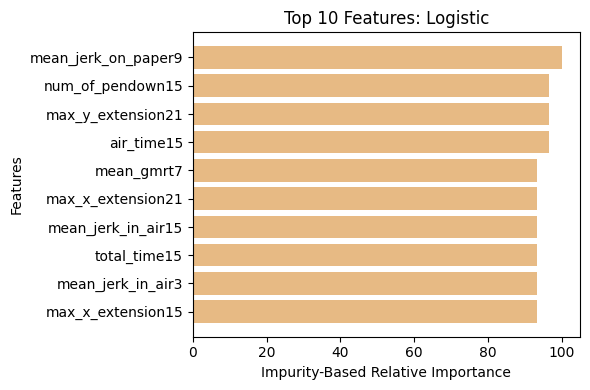

In [10]:
### Model 1: Logistic Regression

# model specification
mod_LR = LogisticRegression(max_iter=50000, random_state=90095)
# cross-validation
mod_LR_cv_metrics = cv_accuracy(mod_LR, 'LR')

# predict training, for out-of-sample evaluation
mod_LR_train = mod_LR.fit(X_train, y_train)
mod_LR_pred_test = mod_LR_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_LR_pred_test_label = np.round(mod_LR_pred_test)             # Y_hat

# prediction metrics
mod_LR_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_LR_pred_test_label, title='LR')

print('train:\n', mod_LR_cv_metrics)
print('\n\ntest:\n', mod_LR_test_metrics)

plot_model(y_pred=mod_LR_pred_test, model_title='Logistic')
# plt.savefig('Model-Logistic.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_LR_pred_test_label, model_title='Logistic')
# plt.savefig('CM-Logistic.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_LR_pred_test, model_title='Logistic')
# plt.savefig('ROC-Logistic.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_LR_train, model_title='Logistic')
# plt.savefig('Feat-Logistic.png', dpi=300)
plt.show()

Best Parameters: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 3}


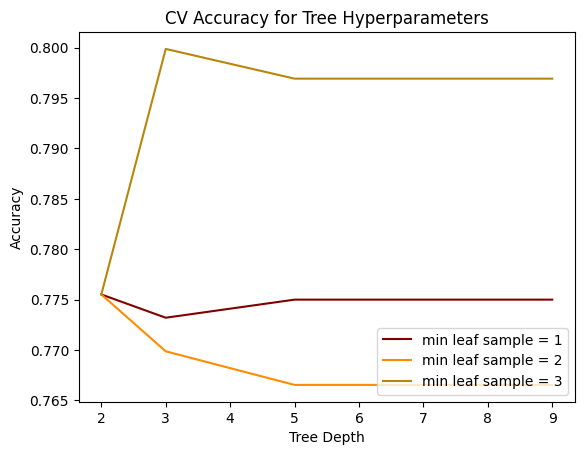

train:
                    DT
Accuracy     0.799872
Sensitivity  0.796667
Specificity  0.802381
F1           0.795387


test:
                    DT
Accuracy     0.735849
Sensitivity  0.758621
Specificity  0.708333
F1           0.758621


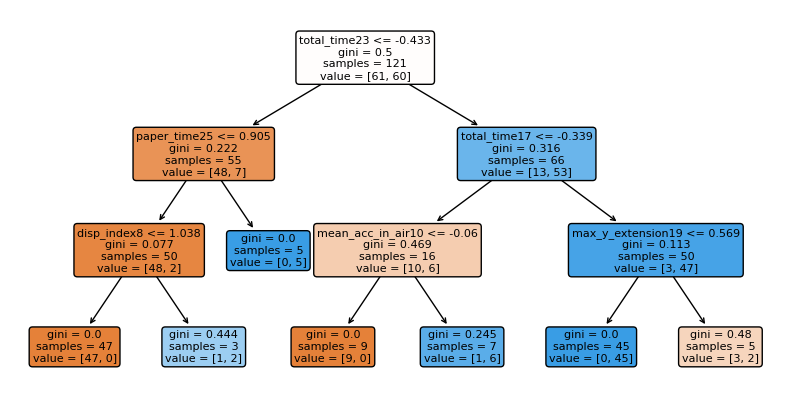

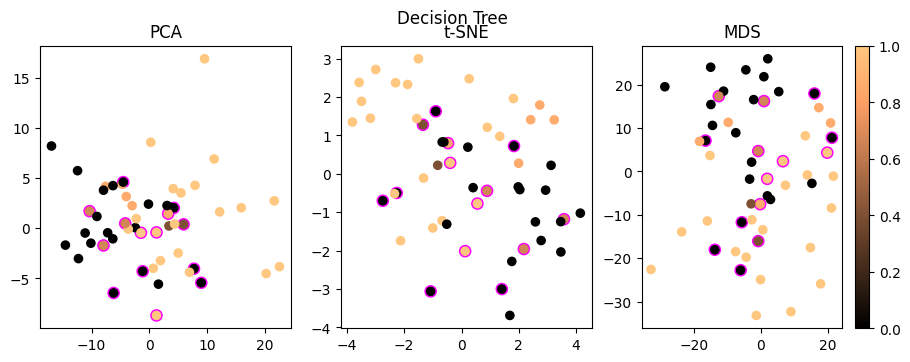

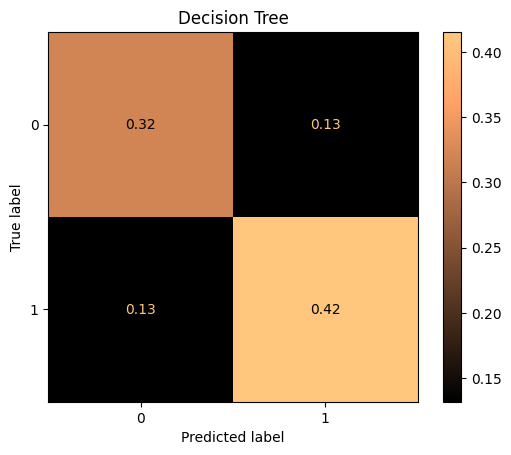

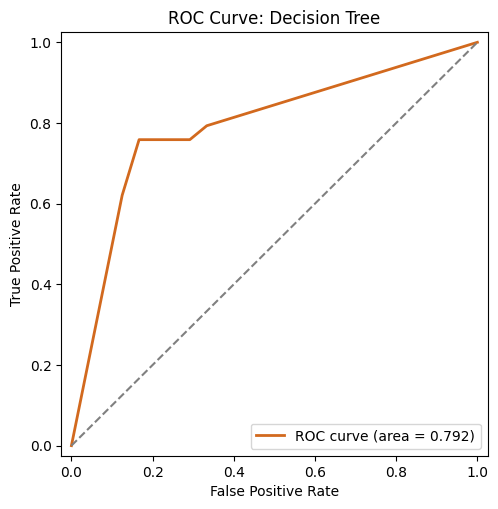

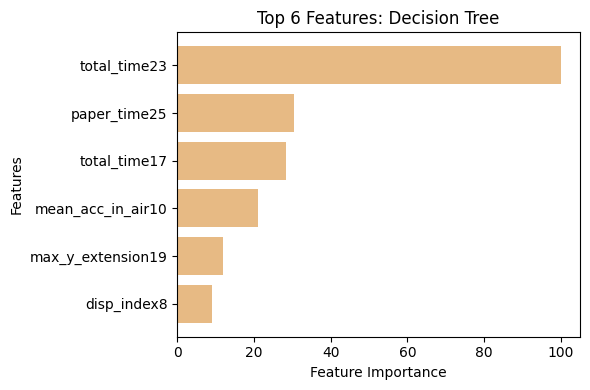

In [11]:
### Model 2: Classification Tree

# grid search for optimal hyperparameters
mod_tree = DecisionTreeClassifier(random_state=90095)
param_grid = {
    'max_depth': [None, 2, 3, 6, 10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.03, 0.06]
}
mod_tree_grid = GridSearchCV(estimator=mod_tree, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_tree_grid.fit(X_train, y_train)

print(f"Best Parameters: {mod_tree_grid.best_params_}")
# also found optimal ccp_alpha = 0

# initialize potential hyperparameters
tree_depths = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 3]
tree_CV_compare = np.empty(shape=(5,3))

# perform grid search for maximum CV accuracy
for i, n in enumerate(tree_depths):
    for  j, m in enumerate(min_samples_leaf):
        # model specification
        mod_tree = DecisionTreeClassifier(random_state=90095, max_depth=n, min_samples_leaf=m)
        # cross-validation
        tree_CV_compare= np.insert(tree_CV_compare, i, [n, m, cv_accuracy(mod_tree, 'Tree')['Tree'][0]], axis=0)
        
# plot tree hyperparameter combinations
tree_CV_compare_df = pd.DataFrame(tree_CV_compare, columns = ['depth', 'min_leaf_samples', 'accuracy'])
plt.plot(tree_CV_compare_df['depth'][tree_CV_compare_df['min_leaf_samples']==1],
         tree_CV_compare_df['accuracy'][tree_CV_compare_df['min_leaf_samples']==1],
         label='min leaf sample = 1', color='maroon')
plt.plot(tree_CV_compare_df['depth'][tree_CV_compare_df['min_leaf_samples']==2],
         tree_CV_compare_df['accuracy'][tree_CV_compare_df['min_leaf_samples']==2],
         label='min leaf sample = 2', color='darkorange')
plt.plot(tree_CV_compare_df['depth'][tree_CV_compare_df['min_leaf_samples']==3],
         tree_CV_compare_df['accuracy'][tree_CV_compare_df['min_leaf_samples']==3],
         label='min leaf sample = 3', color='darkgoldenrod')
plt.legend(loc="lower right")
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.title('CV Accuracy for Tree Hyperparameters')
# plt.savefig('CV-Decision_Tree.png', dpi=300)
plt.show()


# model specification
## optimal: tree_depth = 3, min_samples_leaf = 3
mod_tree = DecisionTreeClassifier(random_state=90095, max_depth=3, min_samples_leaf=3)
# cross-validation
mod_tree_cv_metrics = cv_accuracy(mod_tree, 'DT')

# predict training, for out-of-sample evaluation
mod_tree_train = mod_tree.fit(X_train, y_train)
mod_tree_pred_test = mod_tree_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_tree_pred_test_label = np.round(mod_tree_pred_test)             # Y_hat

# prediction metrics
mod_tree_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_tree_pred_test_label, title='DT')

print('train:\n', mod_tree_cv_metrics)
print('\n\ntest:\n', mod_tree_test_metrics)

# plot final decision tree
plt.figure(figsize=(10, 5))
tree.plot_tree(mod_tree, feature_names=X.columns.tolist(), filled=True, rounded=True, fontsize=8)
# plt.savefig('Tree-Decision_Tree.png', dpi=300)
plt.show()

plot_model(y_pred=mod_tree_pred_test, model_title='Decision Tree')
# plt.savefig('Model-Decision_Tree.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_tree_pred_test_label, model_title='Decision Tree')
# plt.savefig('CM-Decision_Tree.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_tree_pred_test, model_title='Decision Tree')
# plt.savefig('ROC-Decision_Tree.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_tree_train, model_title='Decision Tree')
# plt.savefig('Feat-Decision_Tree.png', dpi=300)
plt.show()

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 163}
train:
                    RF
Accuracy     0.907692
Sensitivity  0.903333
Specificity  0.911429
F1           0.904207


test:
                    RF
Accuracy     0.830189
Sensitivity  0.862069
Specificity  0.791667
F1           0.847458


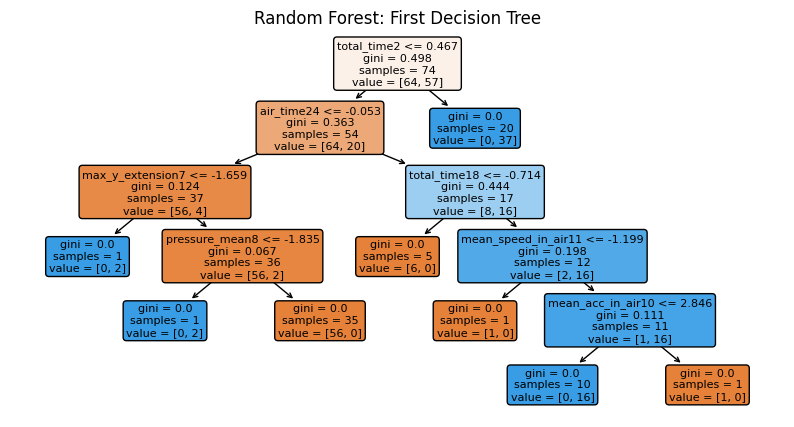

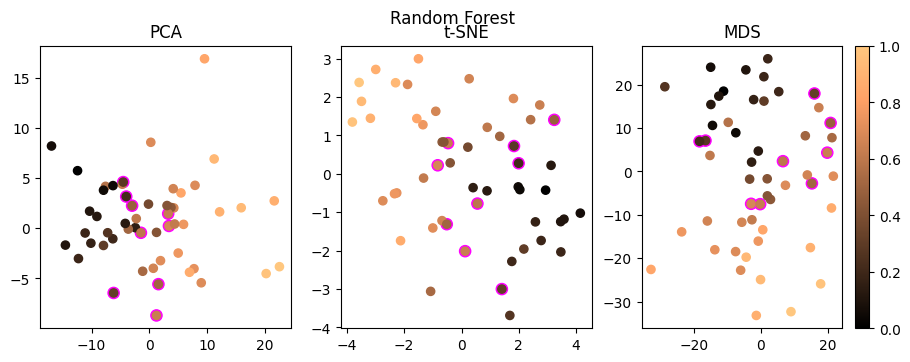

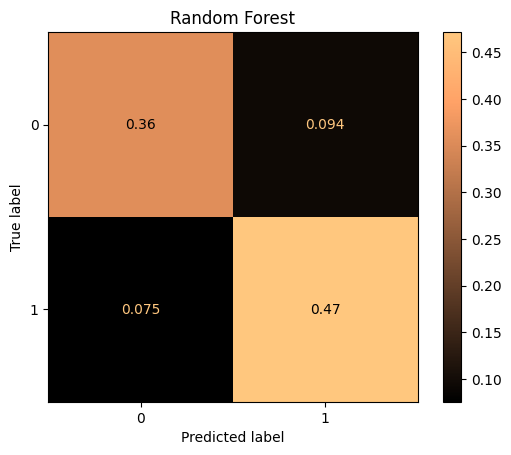

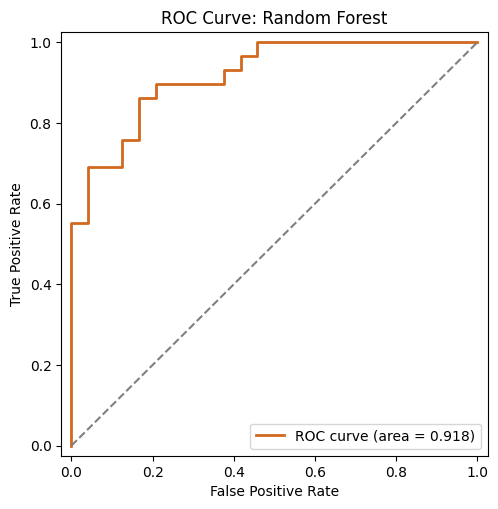

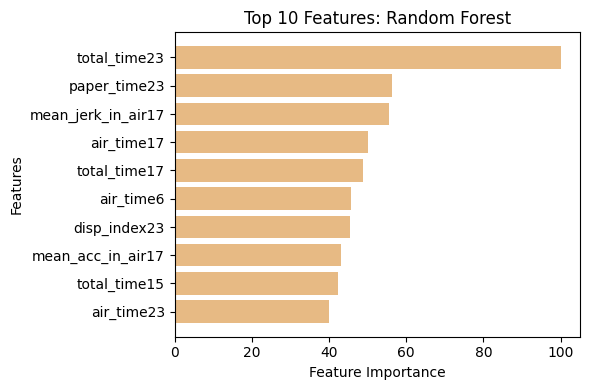

In [12]:
### Model 3: Random Forest

# grid search for optimal hyperparameters
mod_randf = RandomForestClassifier(random_state=90095, oob_score=True, max_features='sqrt')
param_grid = {
    'n_estimators': [160, 163, 165, 167], # anything lower or higher performed worse
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 2, 3]  
}
mod_randf_grid = GridSearchCV(estimator=mod_randf, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_randf_grid.fit(X_train, y_train)
print(f"Best Parameters: {mod_randf_grid.best_params_}")


# model specification
## optimal: tree_depth = 5, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 163
mod_randf = RandomForestClassifier(random_state=90095, oob_score=True, max_features='sqrt',
                                   max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=163)
# cross-validation
mod_randf_cv_metrics = cv_accuracy(mod_randf, 'RF')

# predict training, for out-of-sample evaluation
mod_randf_train = mod_randf.fit(X_train, y_train)
mod_randf_pred_test = mod_randf_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_randf_pred_test_label = np.round(mod_randf_pred_test)             # Y_hat

# prediction metrics
mod_randf_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_randf_pred_test_label, title='RF')

print('train:\n', mod_randf_cv_metrics)
print('\n\ntest:\n', mod_randf_test_metrics)
 
# plot first decision tree
plt.figure(figsize=(10, 5))
tree.plot_tree(mod_randf.estimators_[0], feature_names=X.columns.tolist(), filled=True, rounded=True, fontsize=8)
plt.title("Random Forest: First Decision Tree")
# plt.savefig('Tree-Random_Forest.png', dpi=300)
plt.show()

plot_model(y_pred=mod_randf_pred_test, model_title='Random Forest')
# plt.savefig('Model-Random_Forest.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_randf_pred_test_label, model_title='Random Forest')
# plt.savefig('CM-Random_Forest.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_randf_pred_test, model_title='Random Forest')
# plt.savefig('ROC-Random_Forest.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_randf_train, model_title='Random Forest')
# plt.savefig('Feat-Random_Forest.png', dpi=300)
plt.show()

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 250}
train:
                  AdaB
Accuracy     0.925769
Sensitivity  0.906667
Specificity  0.944286
F1           0.921652


test:
                  AdaB
Accuracy     0.830189
Sensitivity  0.827586
Specificity  0.833333
F1           0.842105


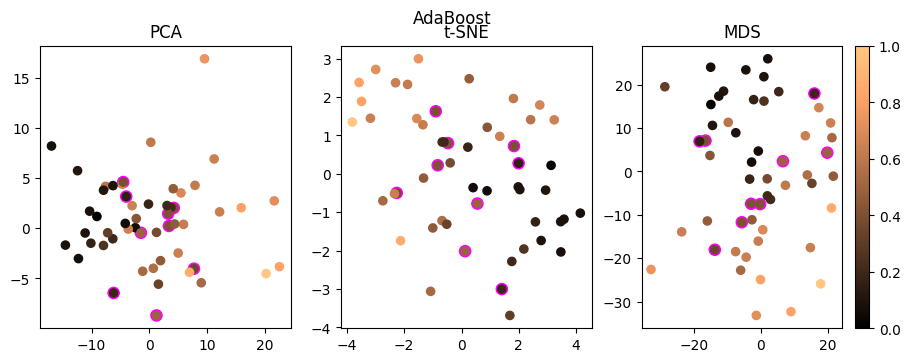

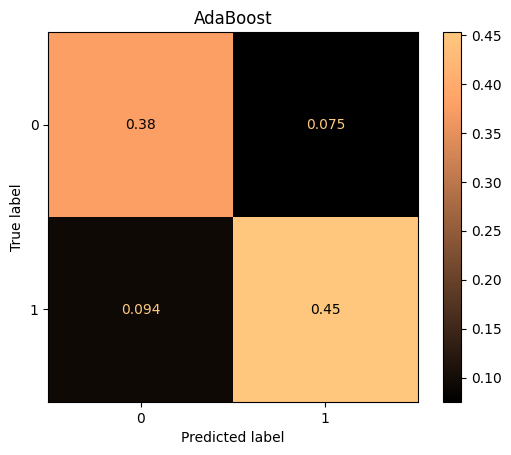

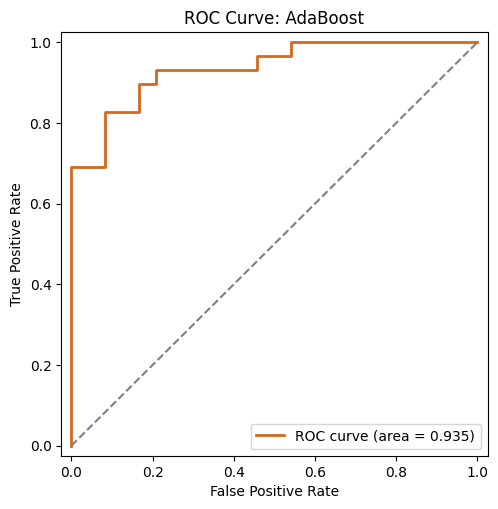

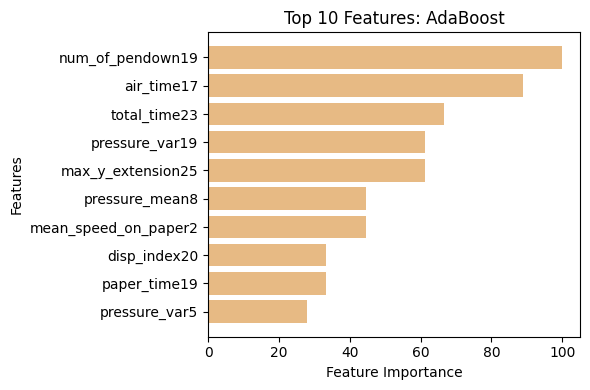

In [13]:
### Model 4: Adaptive Boosting (AdaBoost)

# grid search for optimal hyperparameters
mod_AdaB = AdaBoostClassifier(random_state=90095)
param_grid = {
    'n_estimators': [225, 237, 250, 263, 275],
    'learning_rate': [0.25, 0.375, 0.5, 0.625, 0.75]
}
mod_AdaB_grid = GridSearchCV(estimator=mod_AdaB, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_AdaB_grid.fit(X_train, y_train)
print(f"Best Parameters: {mod_AdaB_grid.best_params_}")


# model specification
## optimal: learning_rate = 0.5, n_estimators = 250
mod_AdaB = AdaBoostClassifier(random_state=90095, learning_rate=0.5, n_estimators=250)
# cross-validation
mod_AdaB_cv_metrics = cv_accuracy(mod_AdaB, 'AdaB')

# predict training, for out-of-sample evaluation
mod_AdaB_train = mod_AdaB.fit(X_train, y_train)
mod_AdaB_pred_test = mod_AdaB_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_AdaB_pred_test_label = np.round(mod_AdaB_pred_test)             # Y_hat

# prediction metrics
mod_AdaB_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_AdaB_pred_test_label, title='AdaB')

print('train:\n', mod_AdaB_cv_metrics)
print('\n\ntest:\n', mod_AdaB_test_metrics)

plot_model(y_pred=mod_AdaB_pred_test, model_title='AdaBoost')
# plt.savefig('Model-AdaBoost.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_AdaB_pred_test_label, model_title='AdaBoost')
# plt.savefig('CM-AdaBoost.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_AdaB_pred_test, model_title='AdaBoost')
# plt.savefig('ROC-AdaBoost.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_AdaB_train, model_title='AdaBoost')
# plt.savefig('Feat-AdaBoost.png', dpi=300)
plt.show()

Best Parameters: {'learning_rate': 0.215, 'max_depth': 1, 'n_estimators': 98}
train:
                   XGB
Accuracy     0.909103
Sensitivity  0.903333
Specificity  0.914286
F1           0.906501


test:
                   XGB
Accuracy     0.849057
Sensitivity  0.827586
Specificity  0.875000
F1           0.857143


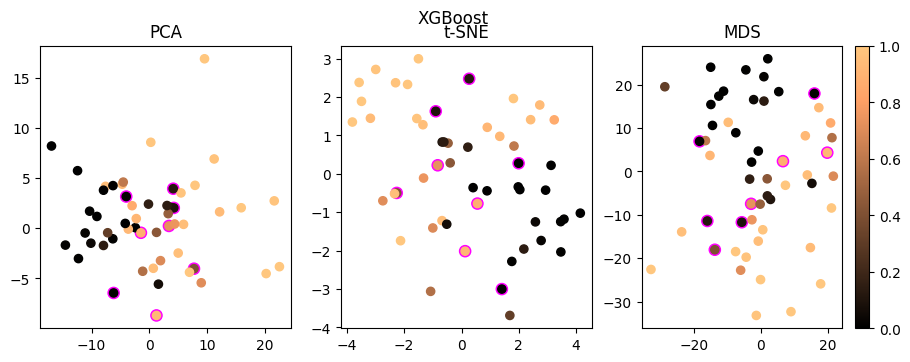

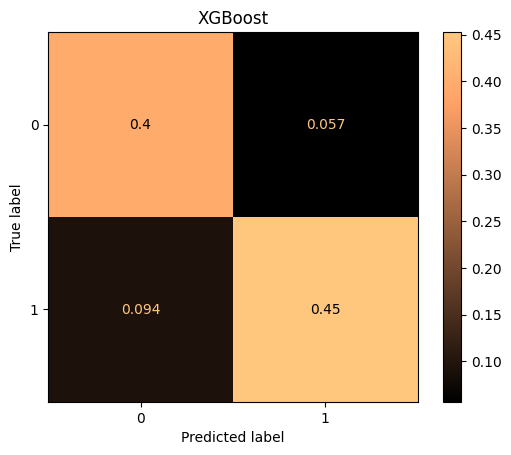

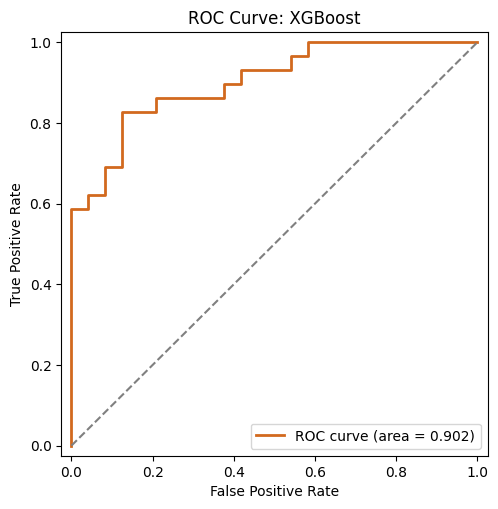

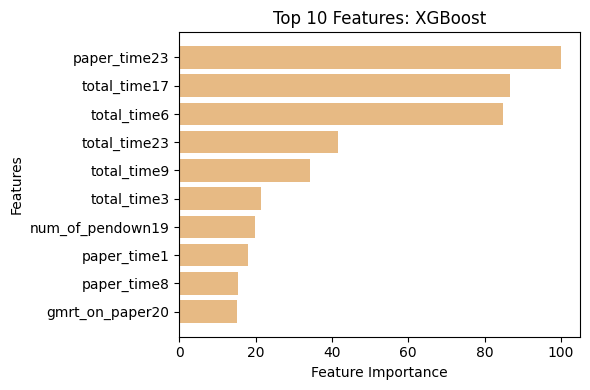

In [14]:
### Model 5: XGBoost

# grid search for optimal hyperparameters
mod_xgb = XGBClassifier(booster='gbtree', tree_method='hist', device='cuda', objective='binary:logistic', seed=90095)
param_grid = {
    'max_depth': [1, 2, 3, 5],
    'learning_rate': [0.2, 0.208, 0.215, 0.232, 0.25],
    'n_estimators': [95, 96, 97, 98, 99, 100]
}

mod_xgb_grid = GridSearchCV(estimator=mod_xgb, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_xgb_grid.fit(X_train, y_train)
print(f"Best Parameters: {mod_xgb_grid.best_params_}")


# model specification
## optimal: max_depth = 1, learning_rate = 0.215, n_estimators = 98
mod_xgb = XGBClassifier(max_depth=1, learning_rate=0.215, n_estimators=98,
                        booster='gbtree', tree_method='hist', device='cuda', objective='binary:logistic', seed=90095)
# cross-validation
mod_xgb_cv_metrics = cv_accuracy(mod_xgb, 'XGB')

# predict training, for out-of-sample evaluation
mod_xgb_train = mod_xgb.fit(X_train, y_train)
mod_xgb_pred_test = mod_xgb_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_xgb_pred_test_label = np.round(mod_xgb_pred_test)             # Y_hat

# prediction metrics
mod_xgb_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_xgb_pred_test_label, title='XGB')

print('train:\n', mod_xgb_cv_metrics)
print('\n\ntest:\n', mod_xgb_test_metrics)

plot_model(y_pred=mod_xgb_pred_test, model_title='XGBoost')
# plt.savefig('Model-XGBoost.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_xgb_pred_test_label, model_title='XGBoost')
# plt.savefig('CM-XGBoost.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_xgb_pred_test, model_title='XGBoost')
# plt.savefig('ROC-XGBoost.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_xgb_train, model_title='XGBoost')
# plt.savefig('Feat-XGBoost.png', dpi=300)
plt.show()

Best Parameters: {'C': 1.1, 'gamma': 'scale'}
train:
                   SVM
Accuracy     0.901154
Sensitivity  0.900000
Specificity  0.901905
F1           0.898593


test:
                   SVM
Accuracy     0.849057
Sensitivity  0.793103
Specificity  0.916667
F1           0.851852


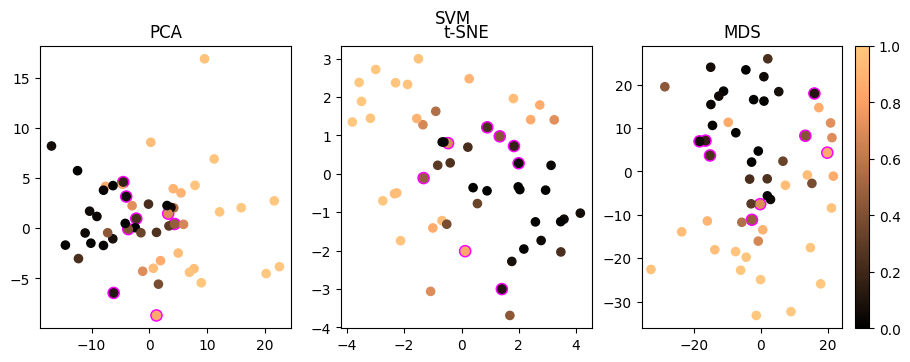

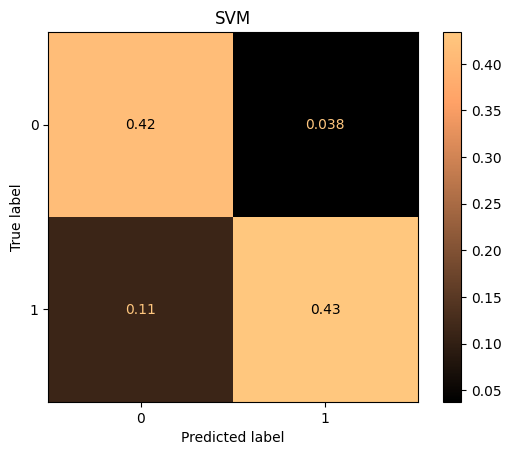

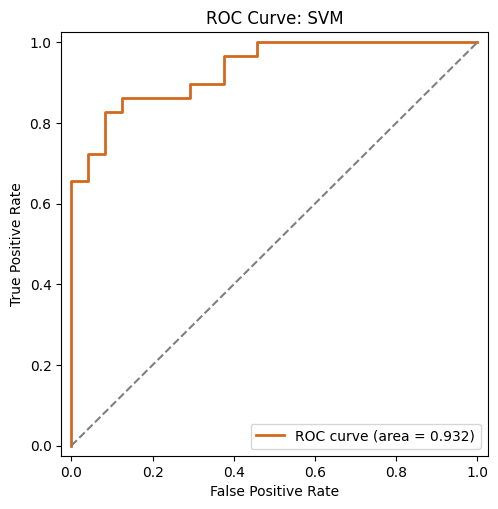

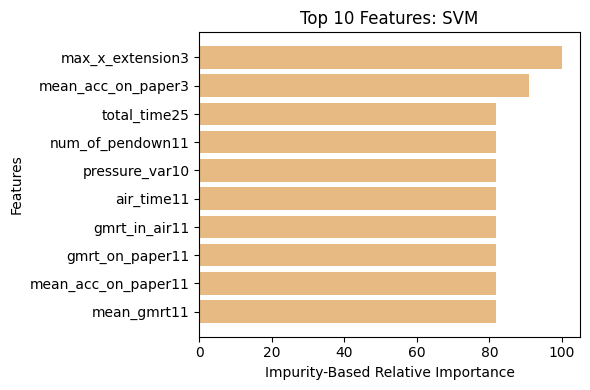

In [15]:
### Model 6: Support Vector Machine (SVM)

# grid search for optimal hyperparameters
mod_svm = SVC(random_state=90095, probability=True, kernel='rbf')
param_grid = {
    'C': [1.0, 1.05, 1.1, 1.15, 1.2],
    'gamma': ['scale', 'auto']
}
mod_svm_grid = GridSearchCV(estimator=mod_svm, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_svm_grid.fit(X_train, y_train)
print(f"Best Parameters: {mod_svm_grid.best_params_}")


# model specification
## optimal: C = 1.1, gamma = 'scale'
mod_svm = SVC(random_state=90095, probability=True, kernel='rbf', C=1.1, gamma='scale')
# cross-validation
mod_svm_cv_metrics = cv_accuracy(mod_svm, 'SVM')

# predict training, for out-of-sample evaluation
mod_svm_train = mod_svm.fit(X_train, y_train)
mod_svm_pred_test = mod_svm_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_svm_pred_test_label = np.round(mod_svm_pred_test)             # Y_hat

# prediction metrics
mod_svm_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_svm_pred_test_label, title='SVM')

print('train:\n', mod_svm_cv_metrics)
print('\n\ntest:\n', mod_svm_test_metrics)

plot_model(y_pred=mod_svm_pred_test, model_title='SVM')
# plt.savefig('Model-SVM.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_svm_pred_test_label, model_title='SVM')
# plt.savefig('CM-SVM.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_svm_pred_test, model_title='SVM')
# plt.savefig('ROC-SVM.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_svm_train, model_title='SVM')
# plt.savefig('Feat-SVM.png', dpi=300)
plt.show()

Best Parameters: {'hidden_layer_sizes': (10, 40, 50), 'learning_rate_init': 0.0001}
train:
                   MLP
Accuracy     0.917821
Sensitivity  0.946667
Specificity  0.889048
F1           0.919635


test:
                   MLP
Accuracy     0.830189
Sensitivity  0.827586
Specificity  0.833333
F1           0.842105


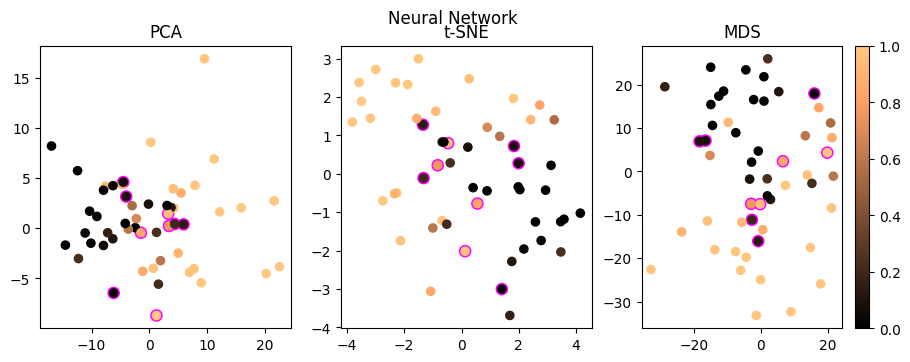

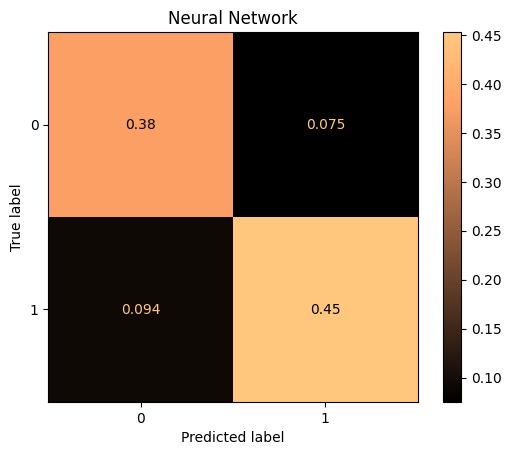

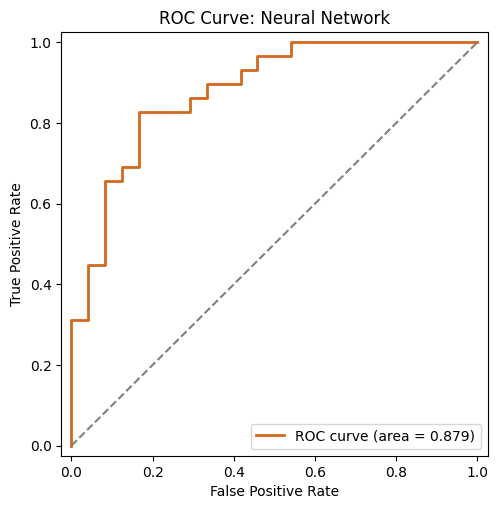

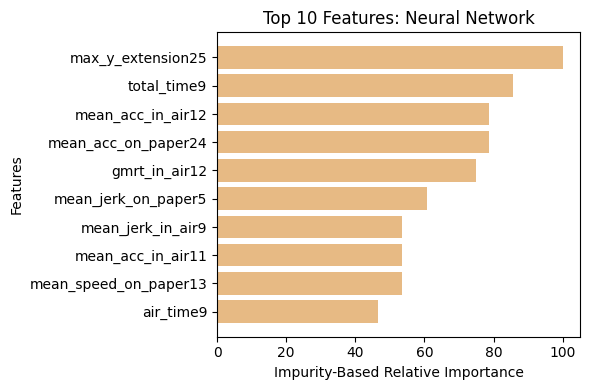

In [16]:
### Model 7: Neural Network (MLP)

# grid search for optimal hyperparameters
## tried 1, 2, and 3 hidden layers: 3 performed best on CV accuracy
mod_mlp = MLPClassifier(random_state=90095, max_iter=10000, solver='adam', activation='relu', learning_rate='constant', alpha=0)
param_grid = {
    'hidden_layer_sizes': [(i,j,k) for i in (5, 10, 25, 50)
                                    for j in (10, 25, 40, 50)
                                    for k in (10, 25, 40, 50)],
    'learning_rate_init': [0.0001, 0.001],
}
mod_mlp_grid = GridSearchCV(estimator=mod_mlp, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_mlp_grid.fit(X_train, y_train)
print(f"Best Parameters: {mod_mlp_grid.best_params_}")


# model specification
## optimal: hidden_layer_sizes = (10, 40, 50), learning_rate_init = 0.0001
mod_mlp = MLPClassifier(random_state=90095, max_iter=10000, solver='adam', activation='relu', learning_rate='constant',
                        alpha=0, hidden_layer_sizes=(10, 40, 50), learning_rate_init=0.0001)
# cross-validation
mod_mlp_cv_metrics = cv_accuracy(mod_mlp, 'MLP')

# predict training, for out-of-sample evaluation
mod_mlp_train = mod_mlp.fit(X_train, y_train)
mod_mlp_pred_test = mod_mlp_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_mlp_pred_test_label = np.round(mod_mlp_pred_test)             # Y_hat

# prediction metrics
mod_mlp_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_mlp_pred_test_label, title='MLP')

print('train:\n', mod_mlp_cv_metrics)
print('\n\ntest:\n', mod_mlp_test_metrics)

plot_model(y_pred=mod_mlp_pred_test, model_title='Neural Network')
# plt.savefig('Model-Neural_Network.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_mlp_pred_test_label, model_title='Neural Network')
# plt.savefig('CM-Neural_Network.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_mlp_pred_test, model_title='Neural Network')
# plt.savefig('ROC-Neural_Network.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_mlp_train, model_title='Neural Network')
# plt.savefig('Feat-Neural_Network.png', dpi=300)
plt.show()

Best Parameters: {'n_neighbors': 1}


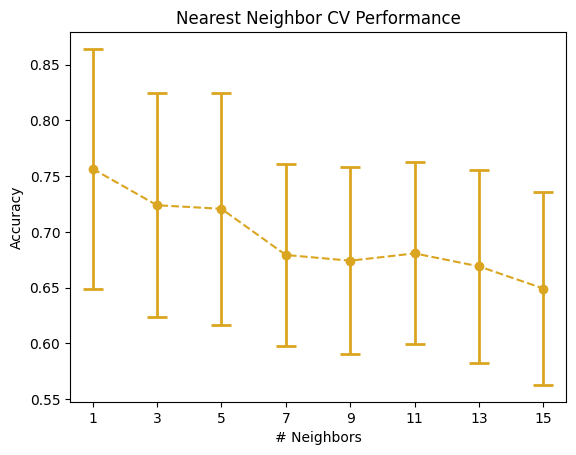

train:
                   KNN
Accuracy     0.756538
Sensitivity  0.510000
Specificity  1.000000
F1           0.646225


test:
                   KNN
Accuracy     0.773585
Sensitivity  0.586207
Specificity  1.000000
F1           0.739130


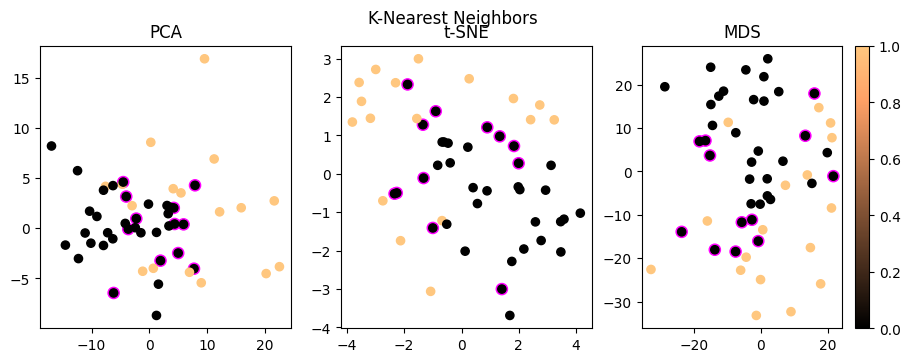

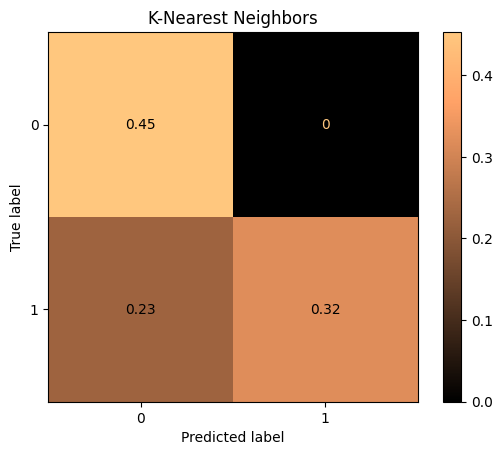

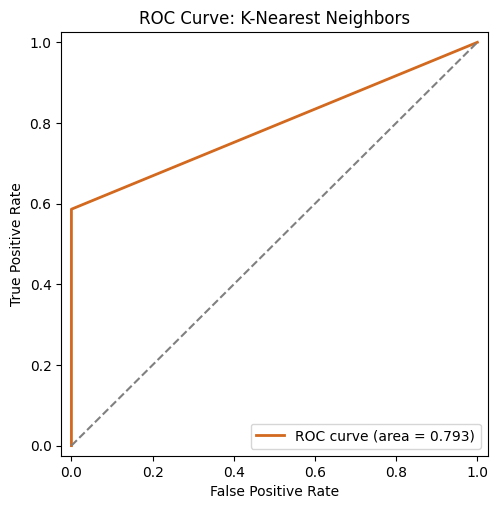

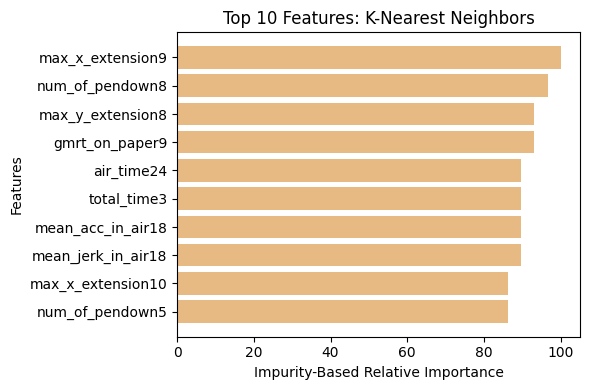

In [17]:
### Model 8: K-Nearest Neighbors

# grid search for optimal hyperparameters
mod_knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 16, 2)
}
mod_knn_grid = GridSearchCV(estimator=mod_knn, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
mod_knn_grid.fit(X_train, y_train)
print(f"Best Parameters: {mod_knn_grid.best_params_}")

# plot optimal parameter search
plt.errorbar(range(1, 16, 2), mod_knn_grid.cv_results_['mean_test_score'], yerr=mod_knn_grid.cv_results_['std_test_score'],
             fmt='--o', color='goldenrod', capsize=7, capthick=2, elinewidth=2)
plt.xticks(range(1, 16, 2))
plt.title('Nearest Neighbor CV Performance')
plt.ylabel('Accuracy')
plt.xlabel('# Neighbors')
# plt.savefig('CV-KNN.png', dpi=300)
plt.show()


# model specification
## optimal: n_neighbors = 1
mod_knn = KNeighborsClassifier(n_neighbors=1)
# cross-validation
mod_knn_cv_metrics = cv_accuracy(mod_knn, 'KNN')

# predict training, for out-of-sample evaluation
mod_knn_train = mod_knn.fit(X_train, y_train)
mod_knn_pred_test = mod_knn_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_knn_pred_test_label = np.round(mod_knn_pred_test)             # Y_hat

# prediction metrics
mod_knn_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_knn_pred_test_label, title='KNN')

print('train:\n', mod_knn_cv_metrics)
print('\n\ntest:\n', mod_knn_test_metrics)

plot_model(y_pred=mod_knn_pred_test, model_title='K-Nearest Neighbors')
# plt.savefig('Model-KNN.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_knn_pred_test_label, model_title='K-Nearest Neighbors')
# plt.savefig('CM-KNN.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_knn_pred_test, model_title='K-Nearest Neighbors')
# plt.savefig('ROC-KNN.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_knn_train, model_title='K-Nearest Neighbors')
# plt.savefig('Feat-KNN.png', dpi=300)
plt.show()

train:
                   LDA
Accuracy     0.830897
Sensitivity  0.796667
Specificity  0.863810
F1           0.819187


test:
                   LDA
Accuracy     0.754717
Sensitivity  0.724138
Specificity  0.791667
F1           0.763636


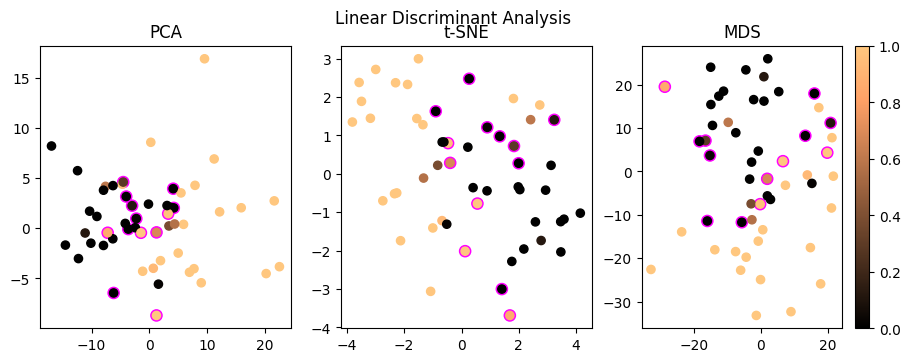

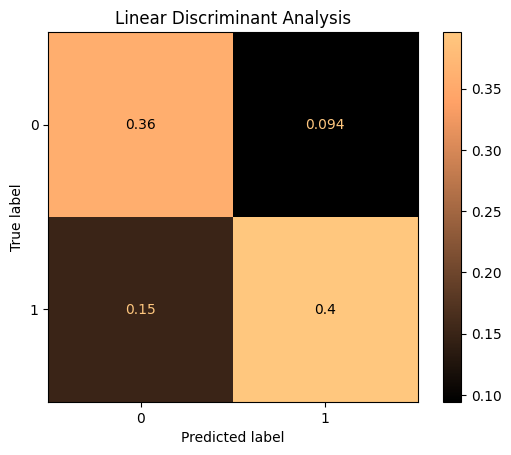

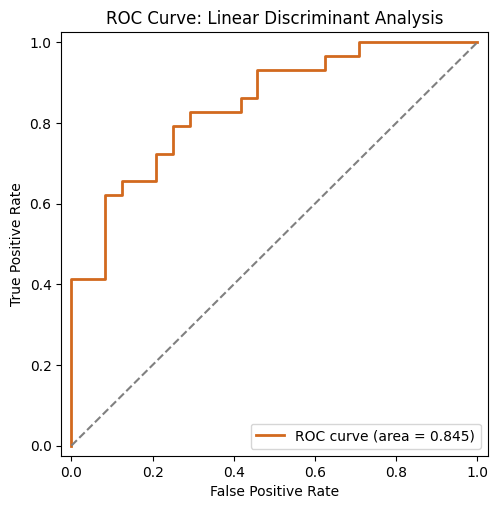

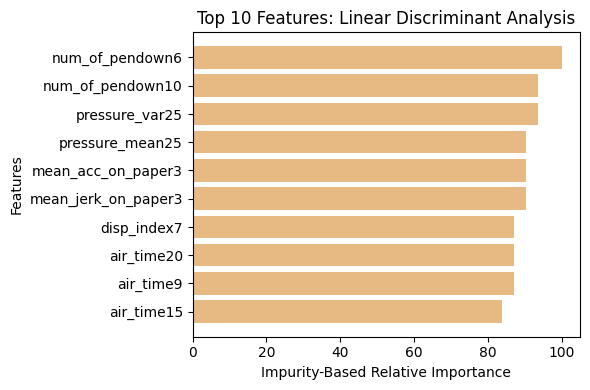

In [18]:
### Model 9: Linear Discriminant Analysis

# model specification
mod_lda = LinearDiscriminantAnalysis()
# cross-validation
mod_lda_cv_metrics = cv_accuracy(mod_lda, 'LDA')

# predict training, for out-of-sample evaluation
mod_lda_train = mod_lda.fit(X_train, y_train)
mod_lda_pred_test = mod_lda_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_lda_pred_test_label = np.round(mod_lda_pred_test)             # Y_hat

# prediction metrics
mod_lda_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_lda_pred_test_label, title='LDA')

print('train:\n', mod_lda_cv_metrics)
print('\n\ntest:\n', mod_lda_test_metrics)

plot_model(y_pred=mod_lda_pred_test, model_title='Linear Discriminant Analysis')
# plt.savefig('Model-LDA.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_lda_pred_test_label, model_title='Linear Discriminant Analysis')
# plt.savefig('CM-LDA.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_lda_pred_test, model_title='Linear Discriminant Analysis')
# plt.savefig('ROC-LDA.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_lda_train, model_title='Linear Discriminant Analysis')
# plt.savefig('Feat-LDA.png', dpi=300)
plt.show()

train:
                    NB
Accuracy     0.886154
Sensitivity  0.853333
Specificity  0.918571
F1           0.876593


test:
                    NB
Accuracy     0.849057
Sensitivity  0.827586
Specificity  0.875000
F1           0.857143


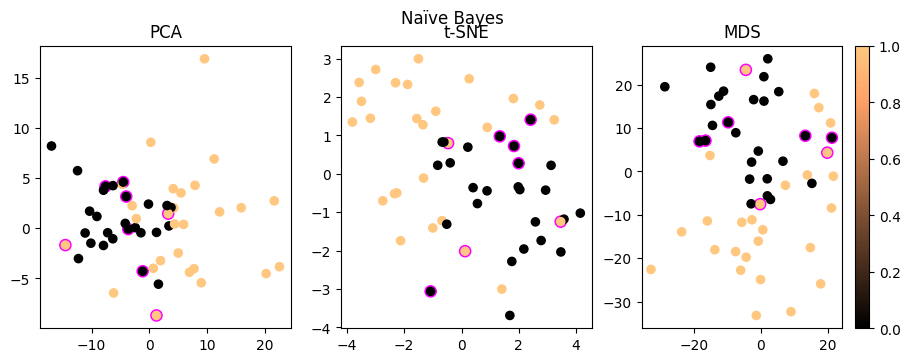

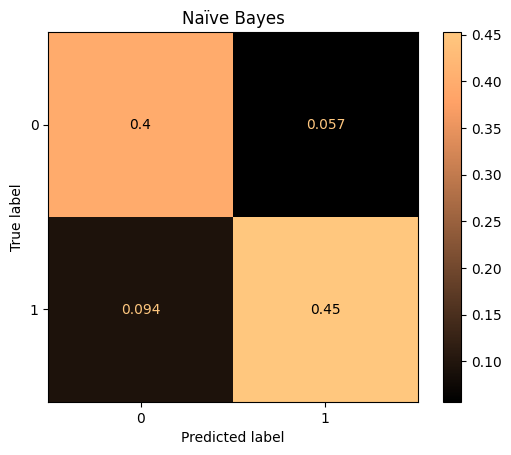

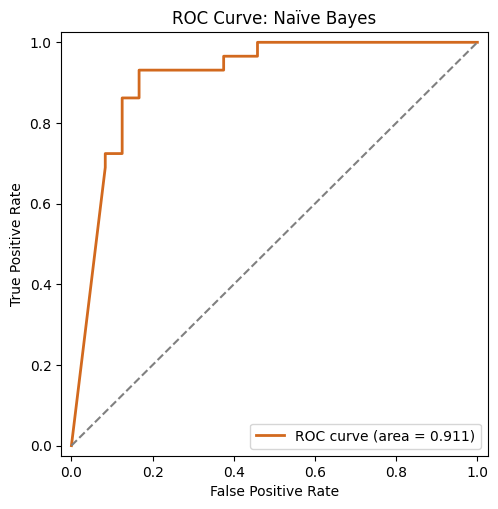

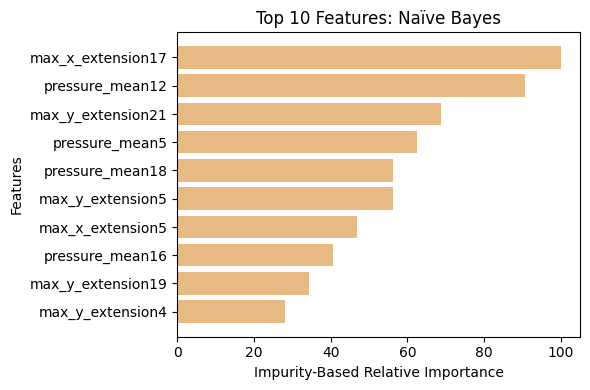

In [19]:
### Model 10: Naïve Bayes

# model specification
mod_nb = GaussianNB()
# cross-validation
mod_nb_cv_metrics = cv_accuracy(mod_nb, 'NB')

# predict training, for out-of-sample evaluation
mod_nb_train = mod_nb.fit(X_train, y_train)
mod_nb_pred_test = mod_nb_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_nb_pred_test_label = np.round(mod_nb_pred_test)             # Y_hat

# prediction metrics
mod_nb_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_nb_pred_test_label, title='NB')

print('train:\n', mod_nb_cv_metrics)
print('\n\ntest:\n', mod_nb_test_metrics)

plot_model(y_pred=mod_nb_pred_test, model_title='Naïve Bayes')
# plt.savefig('Model-Naive_Bayes.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_nb_pred_test_label, model_title='Naïve Bayes')
# plt.savefig('CM-Naive_Bayes.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_nb_pred_test, model_title='Naïve Bayes')
# plt.savefig('ROC-Naive_Bayes.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_nb_train, model_title='Naïve Bayes')
# plt.savefig('Feat-Naive_Bayes.png', dpi=300)
plt.show()

train:
                 stack
Accuracy     0.922692
Sensitivity  0.926667
Specificity  0.918095
F1           0.921625


test:
                 stack
Accuracy     0.849057
Sensitivity  0.862069
Specificity  0.833333
F1           0.862069


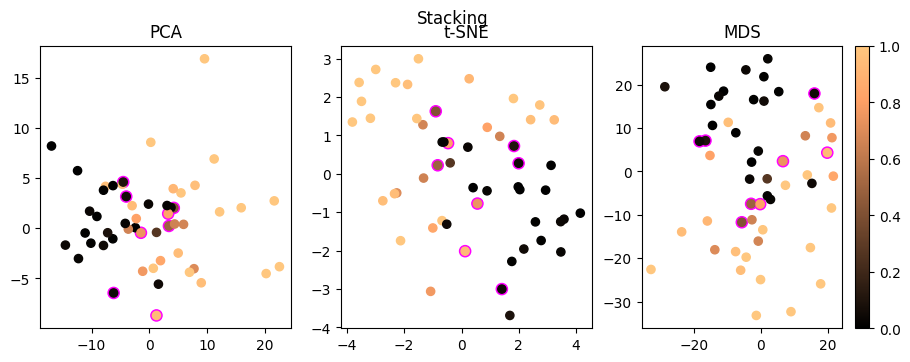

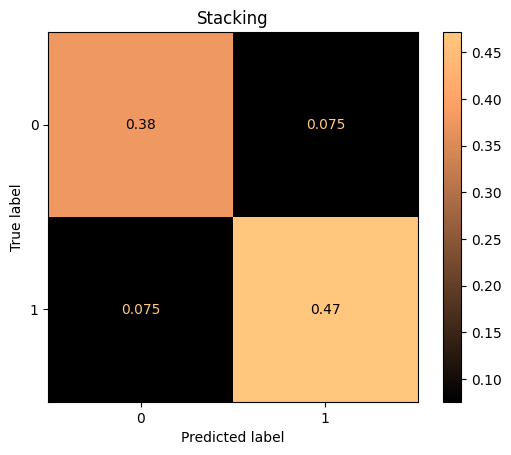

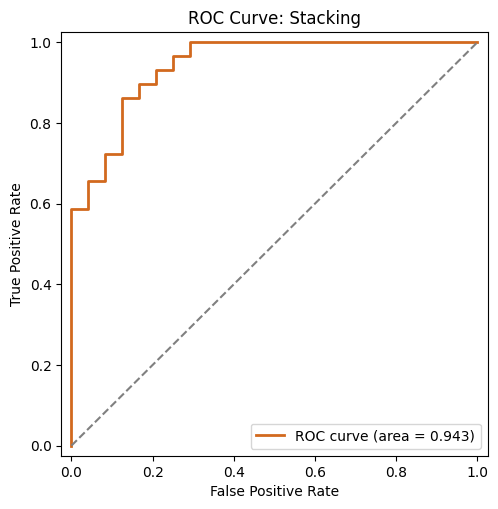

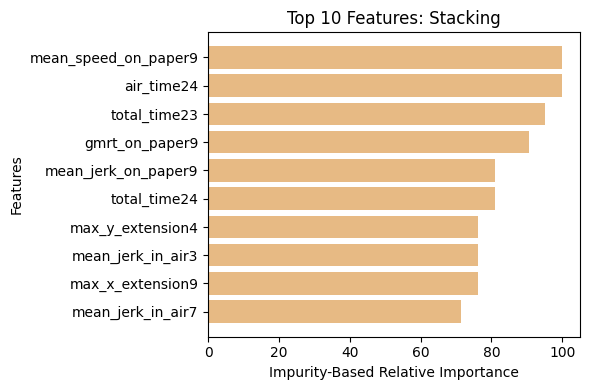

In [20]:
### Model 11: Stacking Classifier

# model specification
all_models = [
    # excluding Nearest Centroid classifier
    ('LR',LogisticRegression(max_iter=50000, random_state=90095)),
    ('DT',DecisionTreeClassifier(random_state=90095, max_depth=3, min_samples_leaf=3)),
    ('RF',RandomForestClassifier(random_state=90095, oob_score=True, max_features='sqrt',
                                 max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=163)),
    ('AdaB',AdaBoostClassifier(random_state=90095, learning_rate=0.5, n_estimators=250)),
    ('XGB',XGBClassifier(max_depth=1, learning_rate=0.215, n_estimators=98,
                         booster='gbtree', tree_method='hist', device='cuda', objective='binary:logistic', seed=90095)),
    ('SVM',SVC(random_state=90095, probability=True, kernel='rbf', C=1.1, gamma='scale')),
    ('MLP',MLPClassifier(random_state=90095, max_iter=10000, solver='adam', activation='relu', learning_rate='constant',
                         alpha=0, hidden_layer_sizes=(10, 40, 50), learning_rate_init=0.0001)),
    ('KNN',KNeighborsClassifier(n_neighbors=1)),
    ('LDA',LinearDiscriminantAnalysis()),
    ('NB',GaussianNB())
]
mod_stack = StackingClassifier(all_models, cv=10, final_estimator=LogisticRegression())
# cross-validation
mod_stack_cv_metrics = cv_accuracy(mod_stack, 'stack')

# predict training, for out-of-sample evaluation
mod_stack_train = mod_stack.fit(X_train, y_train)
mod_stack_pred_test = mod_stack_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_stack_pred_test_label = np.round(mod_stack_pred_test)             # Y_hat

# prediction metrics
mod_stack_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_stack_pred_test_label, title='stack')

print('train:\n', mod_stack_cv_metrics)
print('\n\ntest:\n', mod_stack_test_metrics)

plot_model(y_pred=mod_stack_pred_test, model_title='Stacking')
# plt.savefig('Model-Stacking.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_stack_pred_test_label, model_title='Stacking')
# plt.savefig('CM-Stacking.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_stack_pred_test, model_title='Stacking')
# plt.savefig('ROC-Stacking.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_stack_train, model_title='Stacking')
# plt.savefig('Feat-Stacking.png', dpi=300)
plt.show()

train:
                  vote
Accuracy     0.911154
Sensitivity  0.900000
Specificity  0.921429
F1           0.906749


test:
                  vote
Accuracy     0.849057
Sensitivity  0.827586
Specificity  0.875000
F1           0.857143


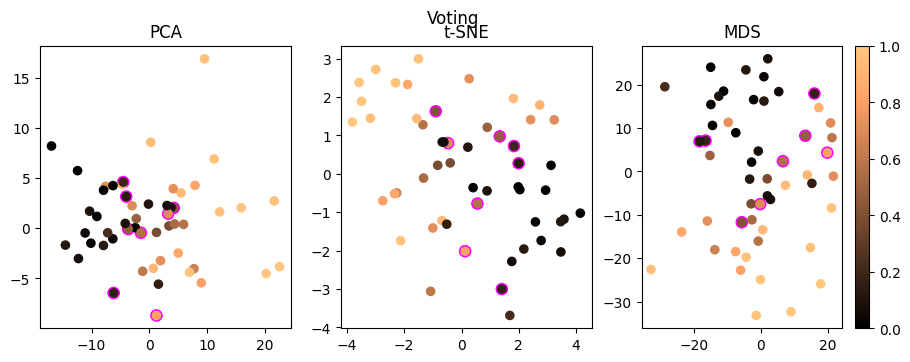

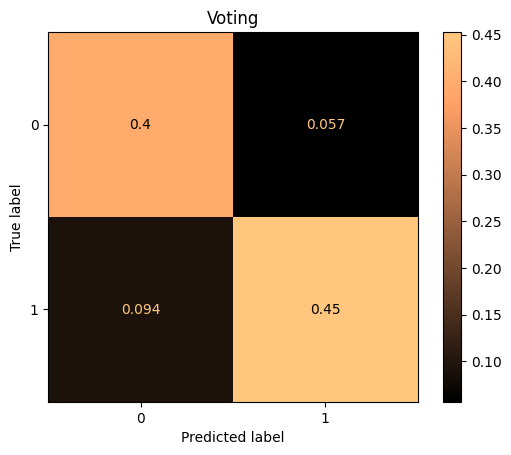

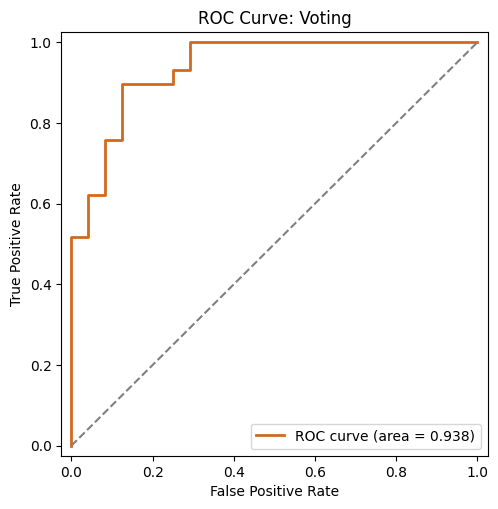

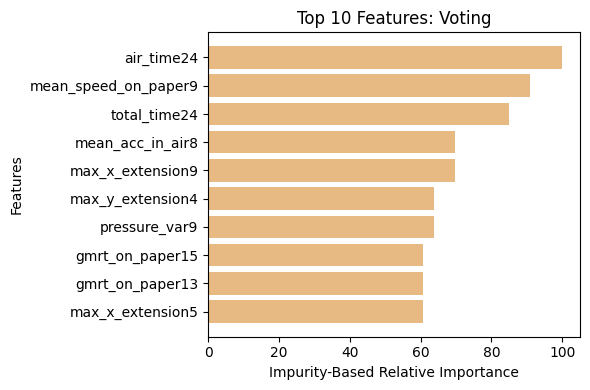

In [21]:
### Model 12: Voting Classifier

# model specification
mod_vote = VotingClassifier(all_models, voting='soft')
# cross-validation
mod_vote_cv_metrics = cv_accuracy(mod_vote, 'vote')

# predict training, for out-of-sample evaluation
mod_vote_train = mod_vote.fit(X_train, y_train)
mod_vote_pred_test = mod_vote_train.predict_proba(X_test)[:,1]      # P(Y_hat=1)
mod_vote_pred_test_label = np.round(mod_vote_pred_test)             # Y_hat

# prediction metrics
mod_vote_test_metrics = test_accuracy(y_true=y_test, y_pred_labels=mod_vote_pred_test_label, title='vote')

print('train:\n', mod_vote_cv_metrics)
print('\n\ntest:\n', mod_vote_test_metrics)

plot_model(y_pred=mod_vote_pred_test, model_title='Voting')
# plt.savefig('Model-Voting.png', dpi=300)
plt.show()
plot_cm(y_pred_labels=mod_vote_pred_test_label, model_title='Voting')
# plt.savefig('CM-Voting.png', dpi=300)
plt.show()
plot_roc(y_pred_labels=mod_vote_pred_test, model_title='Voting')
# plt.savefig('ROC-Voting.png', dpi=300)
plt.show()
plot_feature_importances(model=mod_vote_train, model_title='Voting')
# plt.savefig('Feat-Voting.png', dpi=300)
plt.show()

In [22]:
### Analysis for Conclusions

# training metrics
cv_df = mod_nc_cv_metrics.join(
    [mod_LR_cv_metrics, mod_tree_cv_metrics, mod_randf_cv_metrics, mod_AdaB_cv_metrics, mod_xgb_cv_metrics,
     mod_svm_cv_metrics, mod_mlp_cv_metrics, mod_knn_cv_metrics, mod_lda_cv_metrics, mod_nb_cv_metrics,
     mod_stack_cv_metrics, mod_vote_cv_metrics],
)

# test metrics
test_metrics_df = mod_nc_test_metrics.join(
    [mod_LR_test_metrics, mod_tree_test_metrics, mod_randf_test_metrics, mod_AdaB_test_metrics, mod_xgb_test_metrics,
     mod_svm_test_metrics, mod_mlp_test_metrics, mod_knn_test_metrics, mod_lda_test_metrics, mod_nb_test_metrics,
     mod_stack_test_metrics, mod_vote_test_metrics],
)

# AUC ROC 
roc_df = pd.DataFrame({
    'NC': (roc_auc_score(y_test, mod_nc_pred_test),),
    'LR': (roc_auc_score(y_test, mod_LR_pred_test),),
    'DT': (roc_auc_score(y_test, mod_tree_pred_test),),
    'RF': (roc_auc_score(y_test, mod_randf_pred_test),),
    'AdaB': (roc_auc_score(y_test, mod_AdaB_pred_test),),
    'XGB': (roc_auc_score(y_test, mod_xgb_pred_test),),
    'SVM': (roc_auc_score(y_test, mod_svm_pred_test),),
    'MLP': (roc_auc_score(y_test, mod_mlp_pred_test),),
    'KNN': (roc_auc_score(y_test, mod_knn_pred_test),),
    'LDA': (roc_auc_score(y_test, mod_lda_pred_test),),
    'NB': (roc_auc_score(y_test, mod_nb_pred_test),),
    'stack': (roc_auc_score(y_test, mod_stack_pred_test),),
    'vote': (roc_auc_score(y_test, mod_vote_pred_test),)
}, index=('ROC_AUC',))

test_df = pd.concat([test_metrics_df,roc_df], axis=0)

# top 6 for three measures
print('top 6 for testing data:\n', pd.DataFrame({
    'Accuracy': test_df.sort_values(by=['Accuracy'], axis=1, ascending=False).columns,
    'F1': test_df.sort_values(by=['F1'], axis=1, ascending=False).columns,
    'ROC_AUC': test_df.sort_values(by=['ROC_AUC'], axis=1, ascending=False).columns
}).head(6))

# all measures, sort models by accuracy
print('training:\n', np.round(cv_df.sort_values(by=['Accuracy'], axis=1, ascending=False), 5).T)
print('\n\ntesting:\n', np.round(test_df.sort_values(by=['Accuracy'], axis=1, ascending=False), 5).T)

top 6 for testing data:
   Accuracy     F1 ROC_AUC
0      XGB  stack   stack
1      SVM    XGB    vote
2       NB     NB    AdaB
3    stack   vote     SVM
4     vote    SVM      RF
5       LR     RF      NB
training:
        Accuracy  Sensitivity  Specificity       F1
AdaB    0.92577      0.90667      0.94429  0.92165
stack   0.92269      0.92667      0.91810  0.92163
MLP     0.91782      0.94667      0.88905  0.91964
vote    0.91115      0.90000      0.92143  0.90675
XGB     0.90910      0.90333      0.91429  0.90650
RF      0.90769      0.90333      0.91143  0.90421
SVM     0.90115      0.90000      0.90190  0.89859
NB      0.88615      0.85333      0.91857  0.87659
LR      0.85987      0.85333      0.86667  0.85273
LDA     0.83090      0.79667      0.86381  0.81919
NC      0.82321      0.77667      0.86905  0.80992
DT      0.79987      0.79667      0.80238  0.79539
KNN     0.75654      0.51000      1.00000  0.64623


testing:
        Accuracy  Sensitivity  Specificity       F1  ROC_